In [13]:
import sys
sys.path.append(r'../')
import mat73
import numpy as np
from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
#from keras.utils.np_utils import to_categorical

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%reload_ext autoreload
%autoreload 2
from functions import *

## Reconstruction from macrovariable (Moritz idea)
Reconstructing X from Y

### Loading the macrovariable

In [12]:
X0_tr = np.load('Saved_Y/X0_tr.npy')[:,0,:]
X1_tr = np.load('Saved_Y/X1_tr.npy')[:,0,:]
X0_tst = np.load('Saved_Y/X0_tst.npy')[:,0,:]
X1_tst = np.load('Saved_Y/X1_tst.npy')[:,0,:]
algorithm = 'AbCNet'
Y0_tr = np.loadtxt('Saved_Y/Y0_tr__'+ algorithm +'.csv')
Y1_tr = np.loadtxt('Saved_Y/Y1_tr__'+ algorithm +'.csv')
Y0_tst = np.loadtxt('Saved_Y/Y0_tst__'+ algorithm +'.csv')
Y1_tst = np.loadtxt('Saved_Y/Y1_tst__'+ algorithm +'.csv')
B_train_1 = np.loadtxt('Saved_Y/B_train_1__'+ algorithm +'.csv').astype(int)
B_test_1 = np.loadtxt('Saved_Y/B_test_1__'+ algorithm +'.csv').astype(int)

Y0_tr = Y0_tr.reshape(Y0_tr.shape[0],-1)
Y1_tr = Y1_tr.reshape(Y1_tr.shape[0],-1)
Y0_tst = Y0_tst.reshape(Y0_tst.shape[0],-1)
Y1_tst = Y1_tst.reshape(Y1_tst.shape[0],-1)
Ydiff_tr = Y1_tr - Y0_tr
Ydiff_tst = Y1_tst - Y0_tst

<IPython.core.display.Javascript object>


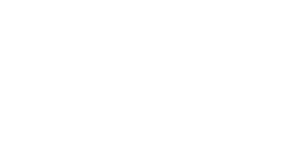

<Axes3DSubplot: >

In [13]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1,show_points=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]

[0.007612346904554925]


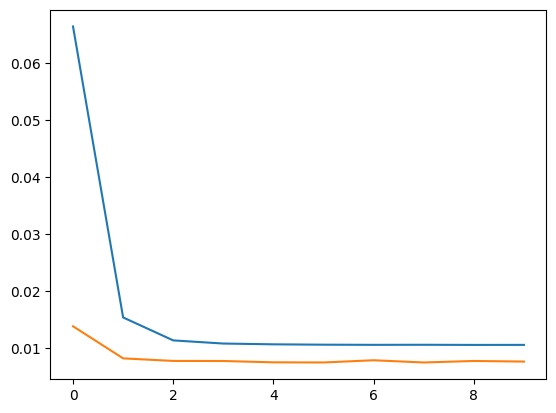

In [14]:
%matplotlib inline
mse_list = []
for i in tqdm(np.arange(1)):
    x_reconstructer = tf.keras.Sequential([
        #layers.Dense(10, activation='relu'),
        #layers.Dense(25, activation='relu'),
        #layers.Dense(30, activation='relu'),
        #layers.Dense(50, activation='relu'),
        layers.Dense(109, activation='linear')
    ]) 

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    x_reconstructer.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])

    history = x_reconstructer.fit(Y1_tr,
                          X1_tr,
                          epochs=10,
                          batch_size=100,
                          validation_data=(Y1_tst, X1_tst),
                          verbose=0
                          )
    # Summarize history for accuracy
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])

    X1_tst_recon = x_reconstructer(Y1_tst).numpy()
    X1_tr_recon = x_reconstructer(Y1_tr).numpy()

    mse_list.append(mean_squared_error(X1_tst_recon, X1_tst))
print(mse_list)

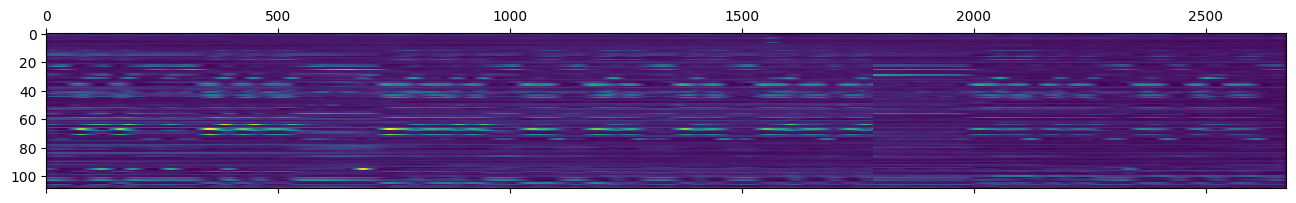

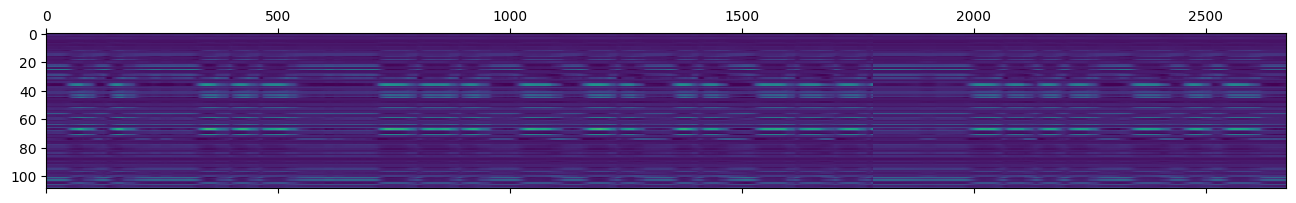

In [15]:
%matplotlib inline
plt.matshow(X1_tr.T, aspect='auto',vmin=0, vmax=2)
plt.matshow(X1_tr_recon.T, aspect='auto', vmin=0, vmax=2)
np.savetxt('Saved_Y/X1_tr_recon',X1_tr_recon)
np.savetxt('Saved_Y/X1_tst_recon',X1_tst_recon)
np.savetxt('Saved_Y/X1_tr',X1_tr)
np.savetxt('Saved_Y/X1_tst',X1_tst)

In [16]:
np.min(np.cov(X1_tr_recon.T))

-0.11067543899933596

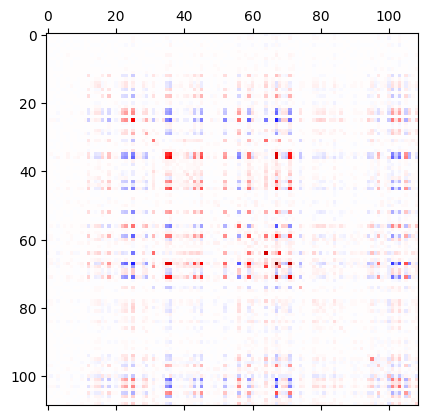

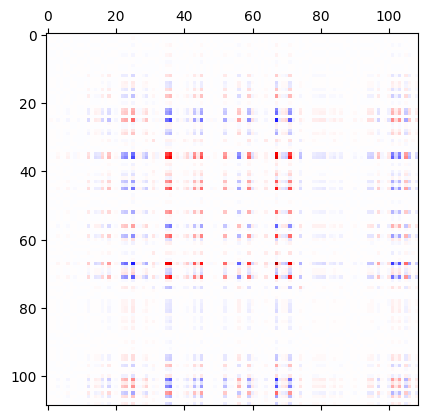

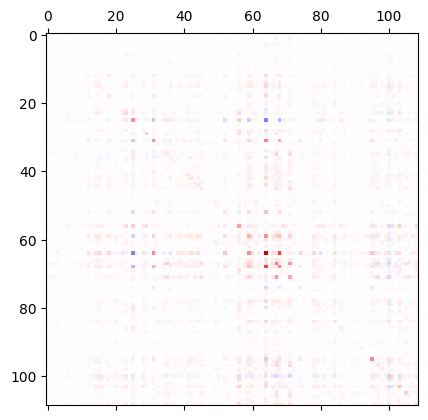

In [17]:
plt.matshow(np.cov(X1_tr.T),vmin=-.25, vmax=.25, cmap='seismic')
plt.matshow(np.cov(X1_tr_recon.T),vmin=-.25, vmax=.25, cmap='seismic')
plt.matshow(np.cov(X1_tr.T) - np.cov(X1_tr_recon.T),vmin=-.25, vmax=.25, cmap='seismic')


In [18]:
X1_tr_recon.shape

(2674, 109)

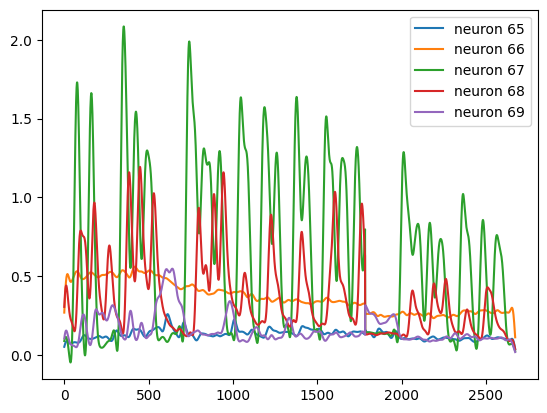

In [19]:
%matplotlib inline
for i in range(65,70):
    plt.plot(X1_tr[:,i], label='neuron '+ str(i))
plt.legend()

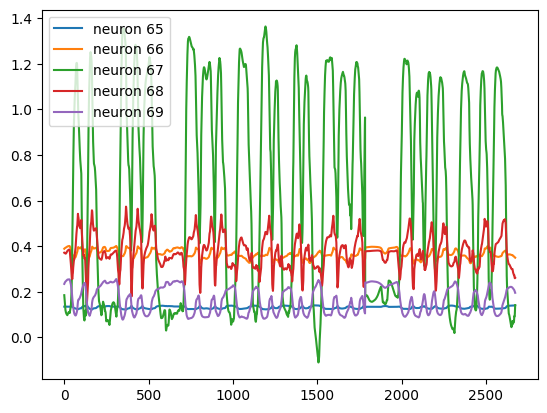

In [20]:
%matplotlib inline
for i in range(65,70):
    plt.plot(X1_tr_recon[:,i], label='neuron '+ str(i))
plt.legend()

In [21]:
dim = 3
pca = PCA(n_components=dim)
pca.fit(X1_tr_recon)
print('Percentage of variance explained by the first ', dim, ' PCs: ', pca.explained_variance_ratio_[:dim].sum().round(3))
X1_tr_recon_pca = pca.transform(X1_tr_recon)
X1_tst_recon_pca = pca.transform(X1_tst_recon)

Percentage of variance explained by the first  3  PCs:  1.0


<IPython.core.display.Javascript object>


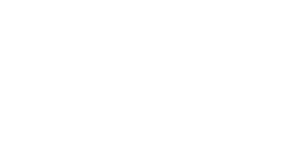

<Axes3DSubplot: >

In [22]:
%matplotlib notebook
plot_phase_space(X1_tr_recon_pca, B_train_1)

<IPython.core.display.Javascript object>


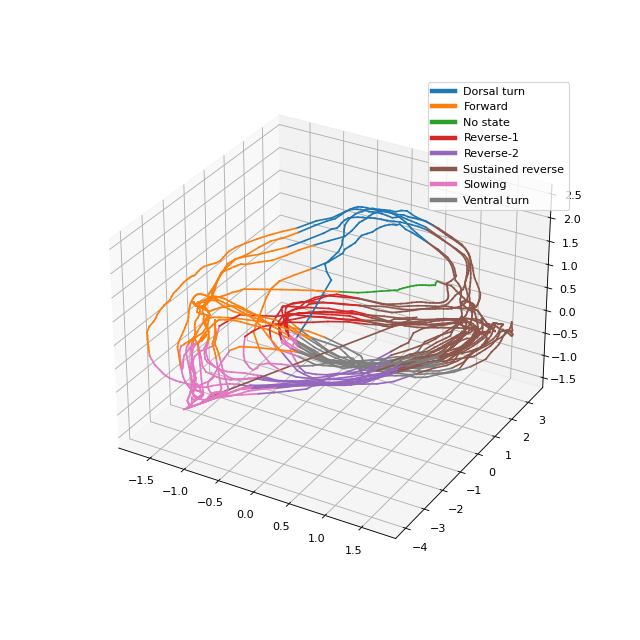

<Axes3DSubplot: >

In [23]:
%matplotlib notebook
plot_phase_space(Y1_tr, B_train_1)